In [9]:
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using Geodesy
using ForwardDiff
using Optim
using Plots

In [10]:
#GS Locations
wean_lla = LLA(40.4427217, -79.9479335, 17.0)
wean_ecef = ECEF(wean_lla, wgs84)
gs_ecef = Array(wean_ecef)./(1000.0)

3-element Array{Float64,1}:
   848.4495513714031
 -4786.358163650972
  4115.532370991342

In [11]:
function ecef2eci(x_ecef,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_eci = [c -s 0; s c 0; 0 0 1]*x_ecef
end

function ecef2eci(x_ecef,v_ecef,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_eci = [c -s 0; s c 0; 0 0 1]*x_ecef
    v_eci = [c -s 0; s c 0; 0 0 1]*(v_ecef + cross([0;0;Ω],x_ecef))
end

function eci2ecef(x_eci,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_ecef = [c -s 0; s c 0; 0 0 1]'*x_eci
end

eci2ecef (generic function with 1 method)

In [12]:
gs_eci = ecef2eci(gs_ecef, 100.0)
gs_ecef - eci2ecef(gs_eci, 100.0)

3-element Array{Float64,1}:
  0.0
 -9.094947017729282e-13
  0.0

In [13]:
function dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [v; a]
end

function backward_dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [-v; -a]
end

function f_c(x)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    return [v; a]
end

function f_d(x)
    h = 0.1 #RK4 step (seconds)
    
    k1 = f_c(x)
    k2 = f_c(x + 0.5*h*k1)
    k3 = f_c(x + 0.5*h*k2)
    k4 = f_c(x + h*k3)
    
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
end

function A(x)
    return ForwardDiff.jacobian(f_d, x)
end

A (generic function with 1 method)

In [27]:
function g(x,t)
    x_gs = ecef2eci(gs_ecef,t)
    v_gs = ecef2eci(gs_ecef,[0.0; 0.0; 0.0],1)
    v_sat = x[4:6]
    
    r = x[1:3]-x_gs
    
    v_r = ((v_sat-v_gs)'*r)/norm(r)
    dopp = -(v_r/3e5)*400e6
end

function g_diffable(xt)
    return g(xt[1:end-1], xt[end])
end

function C(x,t)
    C1 = ForwardDiff.gradient(g_diffable, [x; t])
    return C1[1:end-1]'
end

C (generic function with 1 method)

In [21]:
#Initial Conditions (polar orbit passing directly over GS at t=0)
μ = 398600.44 #km^3/s^2
Re = 6371.0 #km
r0 = (Re+550)*(gs_ecef/norm(gs_ecef))
v0 = cross(r0, cross(r0,[0;0;1]))
v0 = sqrt(μ/norm(r0))*v0/norm(v0)
x0 = [r0; v0]

6-element Array{Float64,1}:
   921.9556818709577
 -5201.028272470356
  4472.084930949979
     0.8559101404321281
    -4.82844558216481
    -5.791927837238977

In [22]:
#Integrate backward for 5 minutes
tspan = (0.0,5.0*60.0)
prob1 = ODEProblem(backward_dynamics!,[r0; v0],tspan)
soln1 = solve(prob1, Tsit5(), reltol=1e-9, abstol=1e-9)

#Integrate forward for 5 minutes
tspan = (0.0,5.0*60.0)
prob2 = ODEProblem(dynamics!,[r0; v0],tspan)
soln2 = solve(prob2, Tsit5(), reltol=1e-9, abstol=1e-9)

#Sample satellite state every 10 seconds
thist = Array(range(-5.0*60.0, 5.0*60.0, step=10.0))
xhist = zeros(6,length(thist))
for k = 1:length(thist)
    if thist[k] < 0.0
        xhist[:,k] .= soln1(-thist[k])
    else
        xhist[:,k] .= soln2(thist[k])
    end
end

In [23]:
#Calculate elevation
ele = zeros(length(thist))
for k = 1:length(thist)
    gs_eci = ecef2eci(gs_ecef,thist[k])
    y = (xhist[1:3,k]-gs_eci)
    ele[k] = (y/norm(y))'*(gs_eci/norm(gs_eci))
end

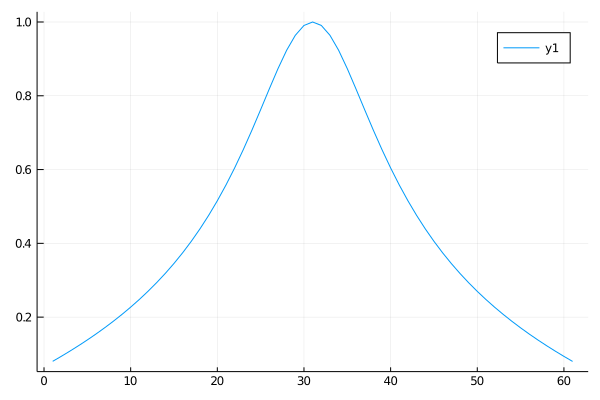

In [24]:
plot(ele)

In [28]:
#Observability Grammian Check
Φ = Array(Diagonal(ones(6)))
J = zeros(3*length(thist),6)
for k = 1:length(thist)
    Φ .= A(xhist[:,k])*Φ
    J[k,:] .= Φ*C(xhist[:,1],thist[1])' #2 recievers
end
Jfact = qr(J)
cond(Jfact.R)

6.805831606526387e9

In [29]:
#Cramer-Rao Bound
R = 0.5^2
Rinv = 1/R

C1 = C(xhist[:,1],thist[1])
S = C1'*Rinv*C1 #inverse state covariance (information)
for k = 2:length(thist)
    Ainv = inv(A(xhist[:,k-1]))
    Ck = C(xhist[:,k],thist[k])
    S = Ainv'*S*Ainv + Ck'*Rinv*Ck
end
sqrt(Diagonal(S^-1))

6×6 Diagonal{Float64,Array{Float64,1}}:
 20.7039   ⋅        ⋅         ⋅         ⋅          ⋅ 
   ⋅      3.03989   ⋅         ⋅         ⋅          ⋅ 
   ⋅       ⋅       0.727639   ⋅         ⋅          ⋅ 
   ⋅       ⋅        ⋅        0.355513   ⋅          ⋅ 
   ⋅       ⋅        ⋅         ⋅        0.0518543   ⋅ 
   ⋅       ⋅        ⋅         ⋅         ⋅         0.0129868

In [30]:
#Generate noisy Measurements
yhist = zeros(length(thist))
for k = 1:length(thist)        
        yhist[k] = g(xhist[:,k], thist[k]) + 3e-5*randn()
end

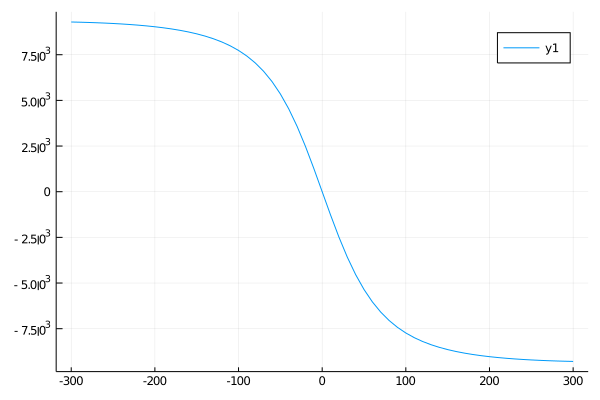

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [31]:
plot(thist,yhist)

In [32]:
function lsobj(x)
    Qinv = Array(Diagonal([1e6*ones(3); 1e8*ones(3)]))
    Rinv = 1/(3e-5*3e-5)
    cost = 0.0
    xhist = reshape(x,6,:)
    for k = 1:(size(xhist,2)-1)
        ex = (xhist[:,k+1]-f_d(xhist[:,k]))
        cost = cost + ex'*Qinv*ex
    end
    for k = 1:(size(xhist,2))
        ey = (yhist[k]-g(xhist[:,k],thist[k]))
        cost = cost + ey'*Rinv*ey
    end
    return cost
end

lsobj (generic function with 1 method)

In [33]:
function gradobj!(g,x)
    ForwardDiff.gradient!(g,lsobj,x)
end

function hessobj!(H,x)
    ForwardDiff.hessian!(H,lsobj,x)
end

hessobj! (generic function with 1 method)

In [ ]:
#This is really slow with more than a couple dozen measurements
#result = optimize(lsobj, gradobj!, hessobj!, xhist[:]+.01*randn(length(xhist[:])), Newton())

In [75]:
#error = xhist - reshape(result.minimizer,6,:)